This code is designed to be used for matano analysis. The section below imports the data, fitting a polynomial to it and defining the area function. 

Metrics 0.994639027877055 0.21666666666666712 0.4654746681256319
Predictions shape (500, 1)


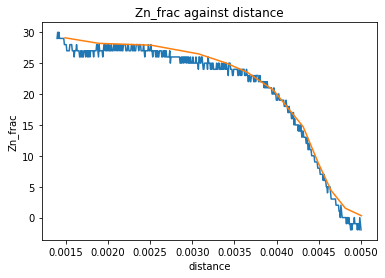

In [223]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from IPython.display import display_html
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor

#
distance = 1e-6*np.asarray([1495, 1895, 2515, 3075, 3405, 3655, 3965, 4315, 4495, 4645, 4815, 5005])
Zn_frac = np.asarray([29.1, 28.2, 27.9, 26.5, 25.0, 23.5, 20.6, 14.7, 8.8, 4.4, 1.5, 0.3])
distance_grad = 1e-03*np.asarray([0.4000, 0.5100, 0.5900, 0.4450, 0.2900, 0.2800, 0.3300, 0.2650, 0.1650, 0.1600, 0.1800, 0.1900])
Zn_frac_grad = np.asarray([-0.9,-0.6,-0.85,-1.45,-1.5,-2.2,-4.4,-5.9,-5.15,-3.65,-2.05,-1.2])
int = 1e-6*np.linspace(1400, 5000, 500)
dydx = distance_grad/Zn_frac_grad

#training model
Xtrain, Xtest, ytrain, ytest = train_test_split(x.reshape(12, 1), y.reshape(12, 1), train_size=0.75)  # split to train and test
GB = GradientBoostingRegressor()
SVR_model = SVR()
MLP = MLPRegressor()
GPR = GaussianProcessRegressor()
degree=13
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())

reg = polyreg.fit(Xtrain,ytrain)
y_pred = reg.predict(Xtest)  # predict values for ytest
R2_RF = r2_score(ytest, y_pred)
mse_RF = mean_squared_error(ytest, y_pred)
RMSE_RF = np.sqrt(mse_RF)
print('Metrics', R2_RF, mse_RF, RMSE_RF)
predictions = reg.predict(int.reshape(len(int), 1))
print('Predictions shape', predictions.shape)
plt.plot(int, reg.predict(int.reshape(len(int), 1)))

plt.title('Zn_frac against distance')
plt.xlabel('distance')
plt.ylabel('Zn_frac')
plt.plot(distance, Zn_frac)
plt.show()

Defining area calculation function (Simpson's Rule)

In [228]:
def area_function(x, y, print_bool):
    area = []
    area_tot = []
    for j in range(len(y)):
        if j%100 == 0 and print_bool == 'yes':
            print(j)
        for i in range(j):
            if i == j:
                area.append((y[-i]/(i+1))*x[-i])
            else:
                if i == 0:
                    area.append((y[-i]/(i+1))*(x[-i]))
                if i%2 == 1:
                    area.append((y[-i]/(i+1))*(4*x[-i]))
                if i%2 == 0:
                    area.append((y[-i]/(i+1))*(4*x[-i]))
        area_tot.append(sum(area))
    print('area is', area_tot)
    return area_tot

This section calculates the matano interface by finding the value that is closest to half the total area and the index of the value. 

In [224]:
area_tot = area_function(int, predictions, print_bool='yes')
area_tot_half = area_tot-area_tot[-1]/2
interface_index = []
for i in range(len(area_tot_half)-1):
    value = area_tot[i]+area_tot_half
    if list(value.flatten())[0] < 1:
        if list(value.flatten())[0] >-1:
            interface_index.append(i)
print(interface_index)
print('interface', int[interface_index[0]])

0
100
200
300
400
area is [0, array([0.203]), array([0.386]), array([0.56234295]), array([0.73868591]), array([0.90706349]), array([1.07212697]), array([1.23435393]), array([1.39162417]), array([1.54669464]), array([1.69978819]), array([1.85108717]), array([2.00074354]), array([2.1503999]), array([2.29865243]), array([2.44559663]), array([2.59131608]), array([2.73473352]), array([2.8770655]), array([3.01734385]), array([3.15664818]), array([3.29502623]), array([3.43340429]), array([3.57093913]), array([3.70847397]), array([3.84600881]), array([3.98280105]), array([4.1195933]), array([4.25638554]), array([4.39317779]), array([4.52997003]), array([4.66676228]), array([4.80355452]), array([4.94034677]), array([5.07770009]), array([5.21614185]), array([5.35458361]), array([5.49353861]), array([5.63299259]), array([5.77341746]), array([5.9147875]), array([6.05707824]), array([6.2002664]), array([6.34432976]), array([6.48967412]), array([6.63626909]), array([6.78408559]), array([6.93309581])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


This section calculates the derivative of the distance w.r.t to the composition. 

In [225]:
interval = 1e-6*np.linspace(1400, 5000, 1000)
dydx = np.divide(np.gradient(int, axis=0).reshape(-1,1), np.gradient(predictions, axis=0))
print(dydx.shape)

(500, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


This section picks out the index of the values closest to the composition percentage required. 

In [226]:
percentages = [5,10,15,20,25]

index_percentages = []
for j in range(len(percentages)):
    index = []
    for i in range(len(predictions)-1):
        value = predictions[i]-percentages[j]
        if list(value.flatten())[0] < 0.1:
            if list(value.flatten())[0] >-0.1:
                index.append(i)
    print(index)
    index_percentages.append(index[0])
    print('percent', percentages[j], 'is', predictions[index[0]])
print(index_percentages)

[442, 443, 445, 446, 447, 448]
percent 5 is [5.]
[418, 419, 420, 421, 422]
percent 10 is [10.]
[389, 391, 392, 393, 394, 395, 397, 400]
percent 15 is [15.]
[353, 354, 355, 357, 358, 359, 363, 364]
percent 20 is [20.]
[186, 202, 203, 205, 208, 212, 215, 217, 218, 220, 221, 222, 224, 225, 226, 227, 229, 230, 231, 235, 236, 239, 242, 243, 244, 245, 246, 249, 250, 251, 253, 255, 256, 262, 265, 266, 270, 273, 275, 276, 278, 282, 283, 284]
percent 25 is [25.]
[442, 418, 389, 353, 186]


This final section calculates the diffusion coefficients for the percentages required. 

In [227]:
diffusion_coefficient = []
for i in range(len(index_percentages)):
    diffusion_coefficient.append(-(2*10*24*3600)**-1 * float(dydx[index_percentages[i]]) * float(np.flip(area_tot)[index_percentages[i]]))
print(diffusion_coefficient)

[7.093777879739132e-11, 1.0829318693117028e-10, 1.6757629585392418e-10, 2.64288674759858e-10, 9.672766904807482e-10]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
